In [1]:
# Dowload the packages
!pip install split-folders

  Obtaining dependency information for split-folders from https://files.pythonhosted.org/packages/b6/d5/307d63c03356bad6e141d8718d3f4116f51bd9c4b09e2614ffcee1f3c6fd/split_folders-0.5.1-py3-none-any.whl.metadata


In [2]:
# Dowload the packages
import numpy as np
import pandas as pd
import os,os.path
import splitfolders

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

matplotlib.style.use('ggplot')
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Set some default variables
DATA_DIR = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SHAPE = (224, 224)

In [4]:
class_names = os.listdir(DATA_DIR)
class_names

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

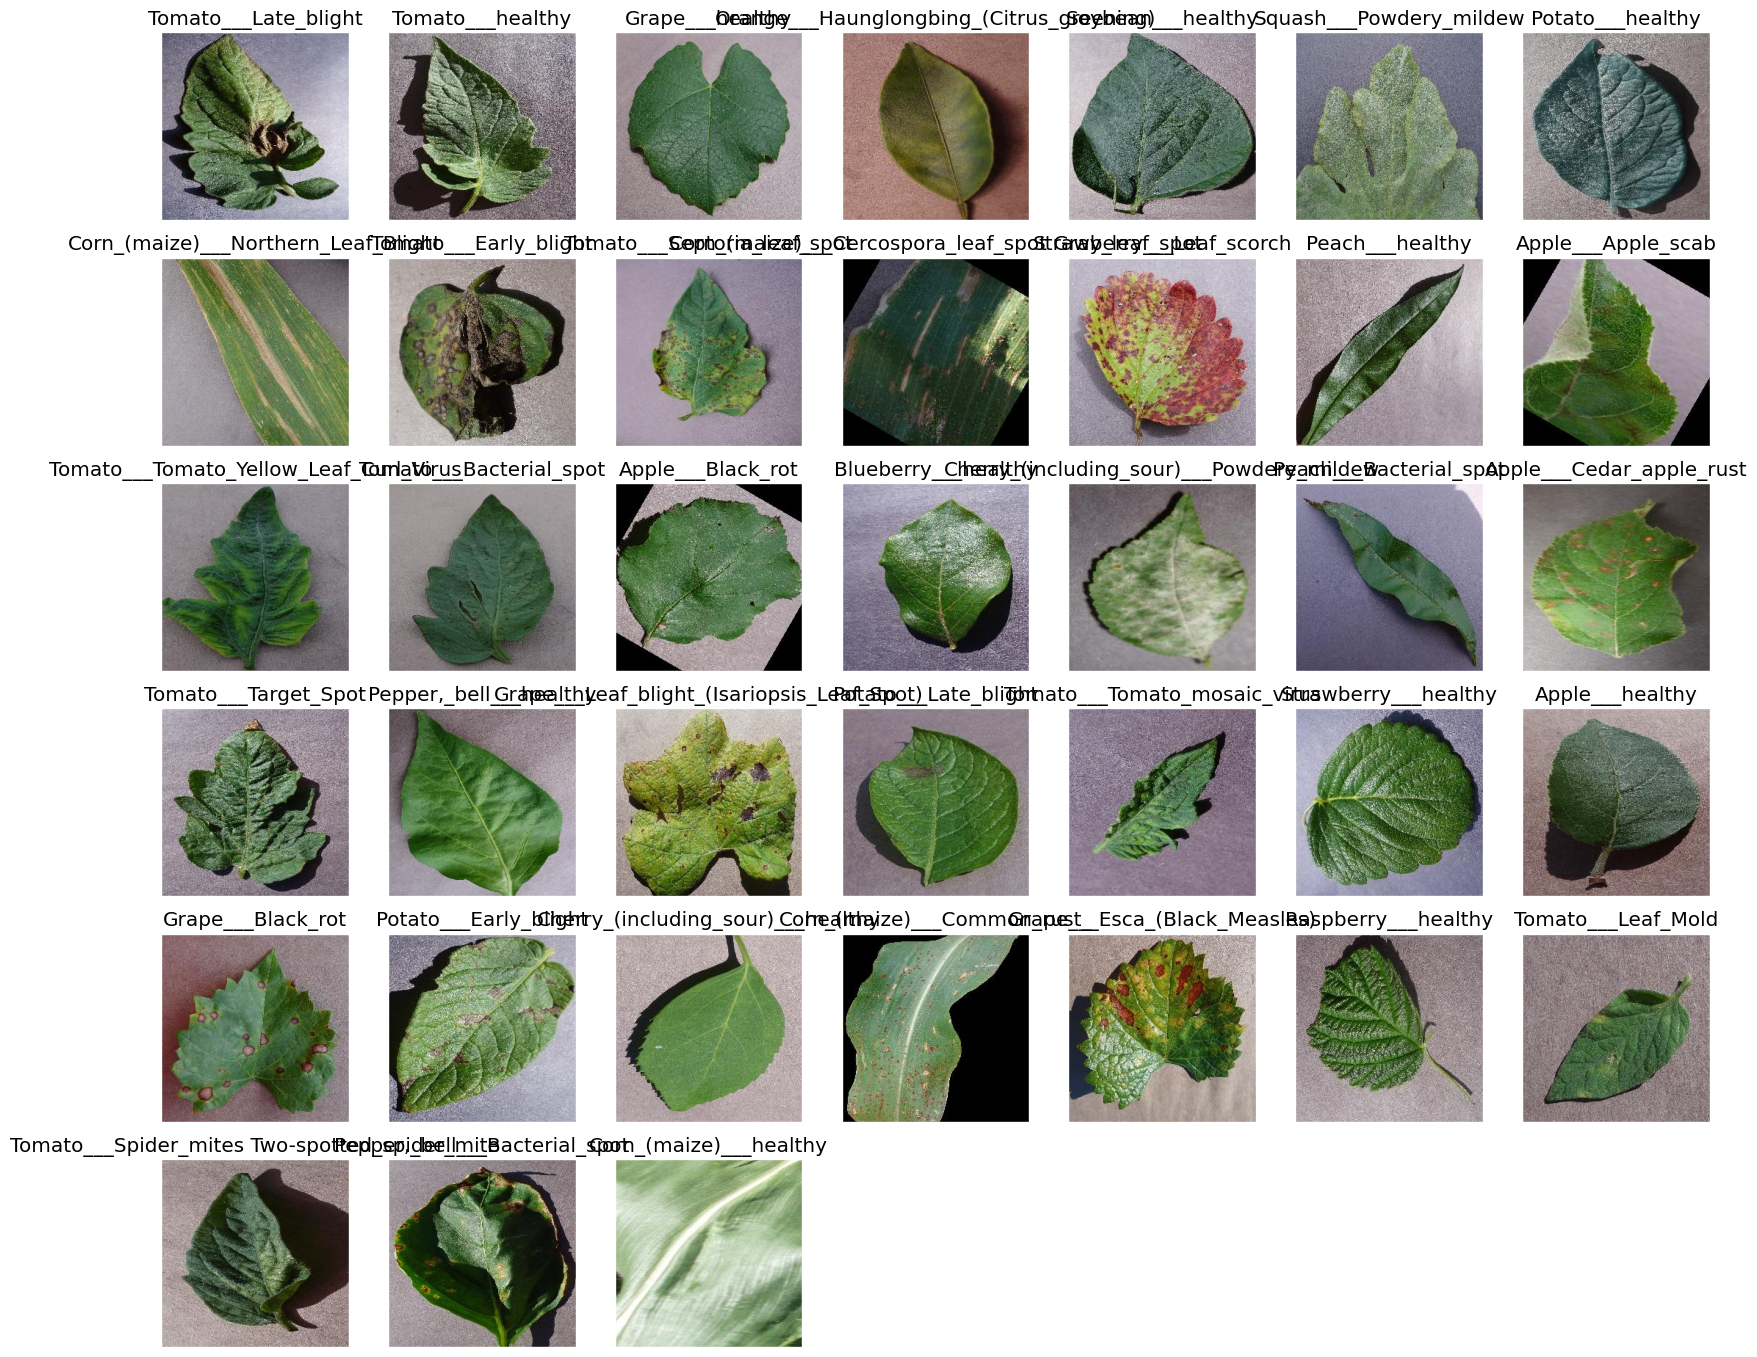

In [5]:
#Visualizing Plant Disease Images by Class
plt.figure(figsize=(20,20))
count=0
for i in os.listdir(DATA_DIR):
  count+=1
  plt.subplot(7,7,count)
  images_path=os.listdir(DATA_DIR+"/"+i)

  image_show=plt.imread(DATA_DIR+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.title(i)
  
  plt.xticks([])
  plt.yticks([])

In [6]:
import keras.backend as K

def f1_macro(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives + K.epsilon())
  precision = TP / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
  accuracy = (K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + 
             K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))) / K.cast(K.shape(y_true)[0], dtype='float32')
  return {
    'f1_macro': 2 * ((precision * recall) / (precision + recall + K.epsilon())),
    'accuracy': accuracy
  }


In [7]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)
    
    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))
    
    pairs.append(columns)
    
pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

Plant                               Disease  \
27                    Apple                               healthy   
20                    Apple                      Cedar_apple_rust   
16                    Apple                             Black_rot   
13                    Apple                            Apple_scab   
17                Blueberry                               healthy   
18  Cherry_(including_sour)                        Powdery_mildew   
30  Cherry_(including_sour)                               healthy   
31             Corn_(maize)                          Common_rust_   
10             Corn_(maize)   Cercospora_leaf_spot Gray_leaf_spot   
37             Corn_(maize)                               healthy   
7              Corn_(maize)                  Northern_Leaf_Blight   
23                    Grape    Leaf_blight_(Isariopsis_Leaf_Spot)   
28                    Grape                             Black_rot   
32                    Grape                  Esca_(Black_Measles)   
2                     Grape                               healthy   
3                    Orange       Haunglongbing_(Citrus_greening)   
19                    Peach                        Bacterial_spot   
12                    Peach                               healthy   
36             Pepper,_bell                        Bacterial_spot   
22             Pepper,_bell                               healthy   
6                    Potato                               healthy   
29                   Potato                          Early_blight   
24                   Potato                           Late_blight   
33                Raspberry                               healthy   
4                   Soybean                               healthy   
5                    Squash                        Powdery_mildew   
26               Strawberry                               healthy   
11               Strawberry                           Leaf_scorch   
34                   Tomato                             Leaf_Mold   
1                    Tomato                               healthy   
35                   Tomato  Spider_mites Two-spotted_spider_mite   
8                    Tomato                          Early_blight   
9                    Tomato                    Septoria_leaf_spot   
21                   Tomato                           Target_Spot   
15                   Tomato                        Bacterial_spot   
14                   Tomato         Tomato_Yellow_Leaf_Curl_Virus   
25                   Tomato                   Tomato_mosaic_virus   
0                    Tomato                           Late_blight   

                                            Directory  Files  
27                                    Apple___healthy   2008  
20                           Apple___Cedar_apple_rust   1760  
16                                  Apple___Black_rot   1987  
13                                 Apple___Apple_scab   2016  
17                                Blueberry___healthy   1816  
18           Cherry_(including_sour)___Powdery_mildew   1683  
30                  Cherry_(including_sour)___healthy   1826  
31                        Corn_(maize)___Common_rust_   1907  
10  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   1642  
37                             Corn_(maize)___healthy   1859  
7                 Corn_(maize)___Northern_Leaf_Blight   1908  
23         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   1722  
28                                  Grape___Black_rot   1888  
32                       Grape___Esca_(Black_Measles)   1920  
2                                     Grape___healthy   1692  
3            Orange___Haunglongbing_(Citrus_greening)   2010  
19                             Peach___Bacterial_spot   1838  
12                                    Peach___healthy   1728  
36                      Pepper,_bell___Bacterial_spot   1913  
22                             Pepper,_bell___healthy   1988  
6      

In [8]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [9]:
# Split the data into folders
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 70295 files [08:20, 140.33 files/s]


In [10]:
# Remove the directories we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]



In [11]:
# Generate batches of tensor image data with real-time data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          shuffle = False)

Found 56219 images belonging to 38 classes.
Found 7013 images belonging to 38 classes.
Found 7063 images belonging to 38 classes.


In [12]:
# Make a directory for models
os.mkdir('models')

# Make subdirectories train, val, test
os.mkdir(os.path.join('models', 'first_version'))

In [13]:
# Here we create checkpoint for the first model
CHECKPOINT_PATH_MODEL_FIRST = "./models/first_version"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH_MODEL_FIRST,
                                      monitor='val_loss',
                                      save_best_only=True)

In [15]:


from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Use pre-trained ResNet152V2 model as the base model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(38, activation='softmax')(x)

# Create the model
resnet152v2_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet152v2_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                           metrics=['accuracy', f1_macro])

# Display the model summary
resnet152v2_model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

In [16]:
#resnet152v2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Number of epochs with no improvement to wait
    verbose=1,  # If set to 1, it prints messages about early stopping to the console
    restore_best_weights=True  # Restore the best weights when stopping
)

In [18]:
history = resnet152v2_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=40,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    verbose=1,
    callbacks=[early_stopping]  # Use early stopping callback based on accuracy
)

Epoch 1/40
440/440 [==============================] - 251s 540ms/step - loss: 0.6428 - accuracy: 0.8070 - val_loss: 0.2266 - val_accuracy: 0.9307
Epoch 2/40
440/440 [==============================] - 232s 527ms/step - loss: 0.2645 - accuracy: 0.9126 - val_loss: 0.1817 - val_accuracy: 0.9388
Epoch 3/40
440/440 [==============================] - 232s 527ms/step - loss: 0.2018 - accuracy: 0.9321 - val_loss: 0.1503 - val_accuracy: 0.9507
Epoch 4/40
440/440 [==============================] - 232s 528ms/step - loss: 0.1685 - accuracy: 0.9414 - val_loss: 0.1312 - val_accuracy: 0.9588
Epoch 5/40
440/440 [==============================] - 232s 527ms/step - loss: 0.1453 - accuracy: 0.9494 - val_loss: 0.1287 - val_accuracy: 0.9572
Epoch 6/40
440/440 [==============================] - 232s 528ms/step - loss: 0.1342 - accuracy: 0.9535 - val_loss: 0.1166 - val_accuracy: 0.9622
Epoch 7/40
440/440 [==============================] - 232s 527ms/step - loss: 0.1234 - accuracy: 0.9574 - val_loss: 0.1229 -

# Model Evaluation Metrics

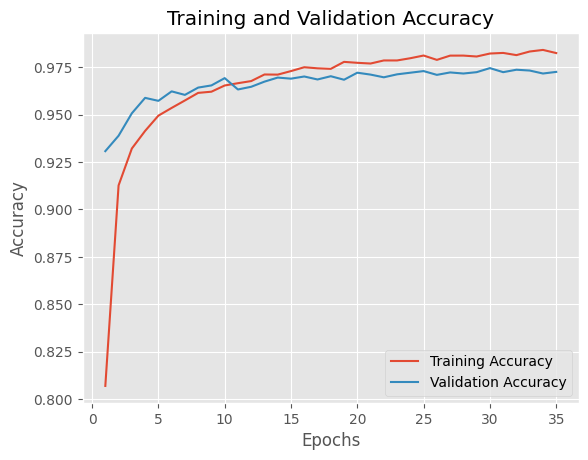

In [19]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy from the 'history' object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epoch numbers
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


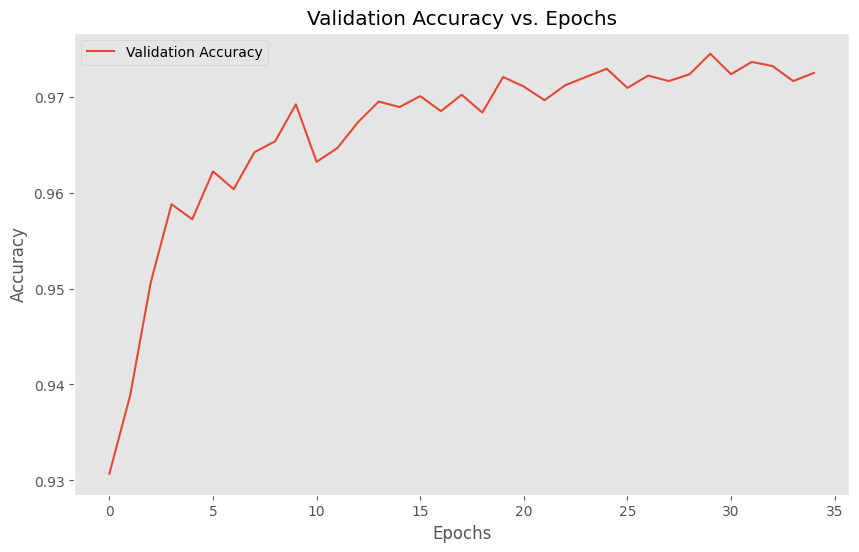

In [20]:
# Plot validation accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()


In [21]:

# Evaluate the model on the test dataset using test_gen
test_loss, test_accuracy = resnet152v2_model.evaluate(test_gen, steps=len(test_gen))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


56/56 [==============================] - 27s 473ms/step - loss: 0.1106 - accuracy: 0.9710
Test Loss: 0.1106, Test Accuracy: 0.9710


In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Predict labels for the test data
predictions = resnet152v2_model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels for the test data
true_labels = test_gen.classes

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(confusion)



56/56 [==============================] - 28s 464ms/step
Confusion Matrix:
[[196   2   0 ...   0   0   0]
 [  0 199   0 ...   0   0   0]
 [  0   0 175 ...   0   0   0]
 ...
 [  0   0   0 ... 192   1   0]
 [  0   0   0 ...   0 176   0]
 [  0   0   0 ...   0   0 185]]


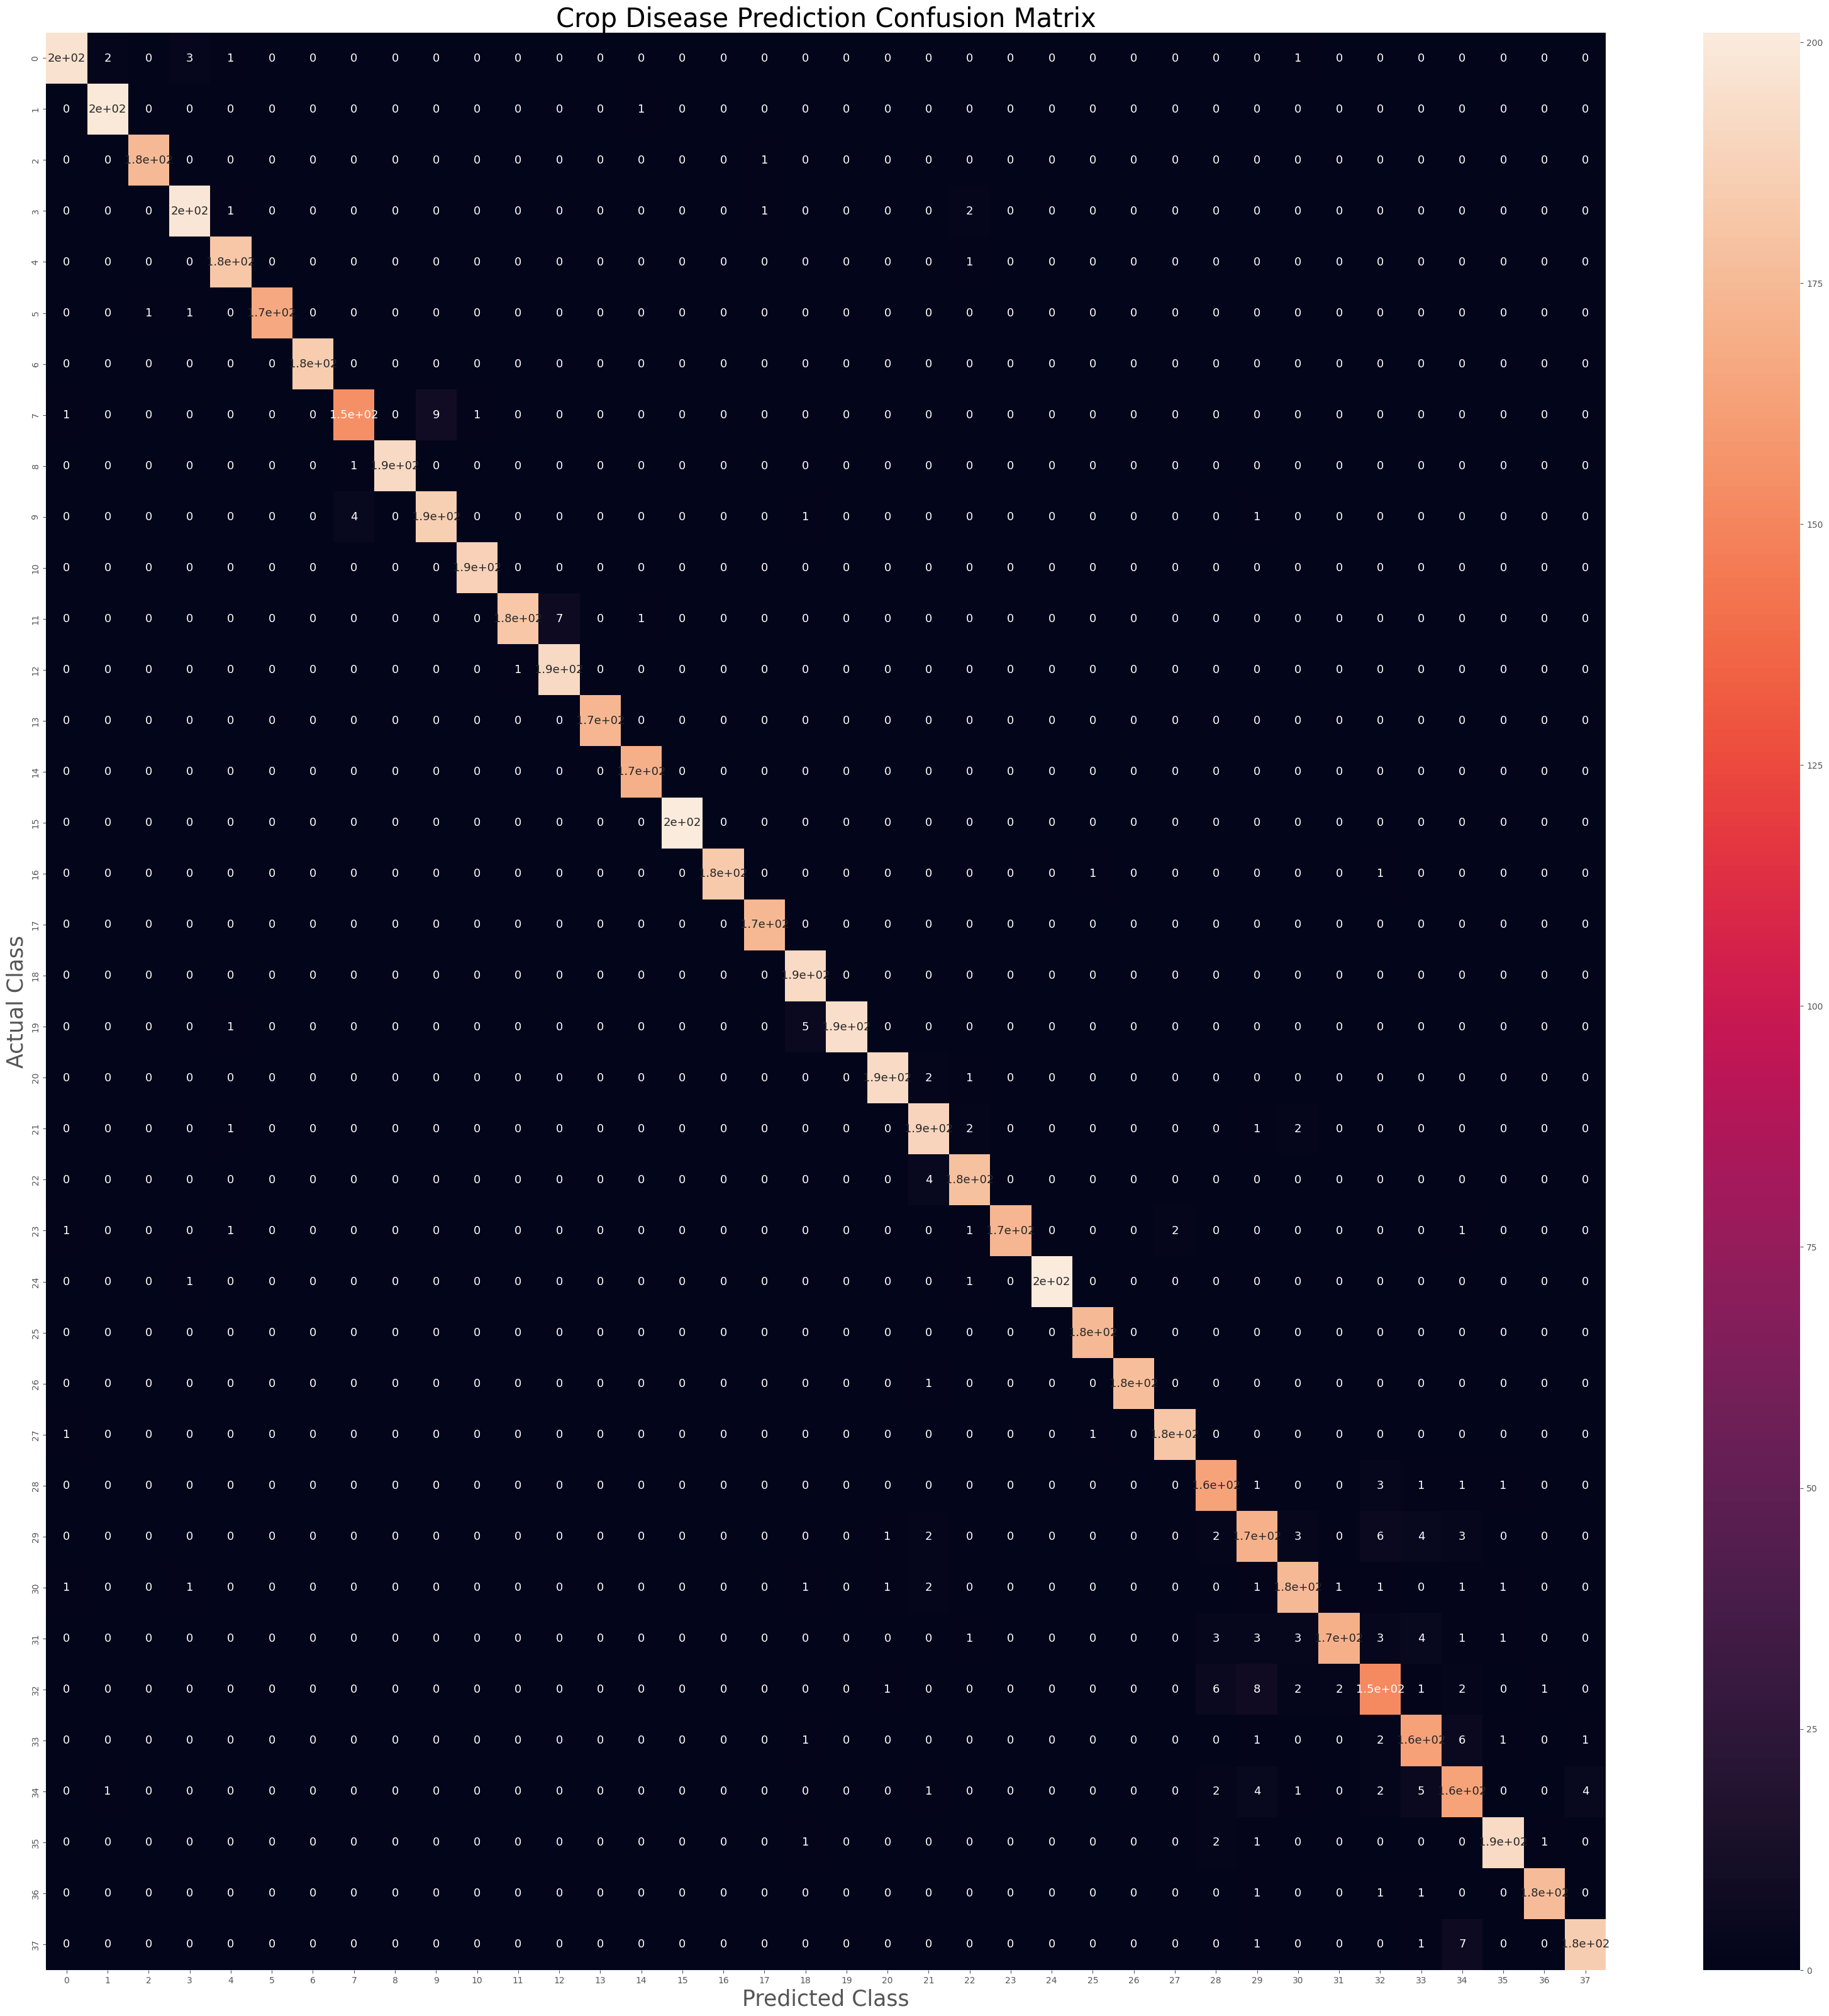

In [23]:
plt.figure(figsize=[40,40])
sns.heatmap(confusion, annot=True, annot_kws={'size':13})
plt.xlabel("Predicted Class", fontsize=25)
plt.ylabel("Actual Class",fontsize=25)
plt.title("Crop Disease Prediction Confusion Matrix",fontsize=30)
plt.show()

In [24]:
# Calculate precision, recall, and F1 score for each class
class_precision = precision_score(true_labels, predicted_labels, average=None)
class_recall = recall_score(true_labels, predicted_labels, average=None)
class_f1_score = f1_score(true_labels, predicted_labels, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = np.mean(class_precision)
macro_recall = np.mean(class_recall)
macro_f1_score = np.mean(class_f1_score)

# Calculate micro-average precision, recall, and F1 score
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
micro_recall = recall_score(true_labels, predicted_labels, average='micro')
micro_f1_score = f1_score(true_labels, predicted_labels, average='micro')
# Create a DataFrame
df = pd.DataFrame({
    'Class': class_names,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1 Score': class_f1_score
})

# Print the DataFrame
print(df.to_string())

# Print Macro and Micro F1 Scores
print(f'Macro-average Precision = {macro_precision:.4f}, Recall = {macro_recall:.4f}, F1 Score = {macro_f1_score:.4f}')
print(f'Micro-average Precision = {micro_precision:.4f}, Recall = {micro_recall:.4f}, F1 Score = {micro_f1_score:.4f}')

                                                 Class  Precision    Recall  F1 Score
0                                 Tomato___Late_blight   0.980000  0.965517  0.972705
1                                     Tomato___healthy   0.985149  0.995000  0.990050
2                                      Grape___healthy   0.994318  0.994318  0.994318
3             Orange___Haunglongbing_(Citrus_greening)   0.970588  0.980198  0.975369
4                                    Soybean___healthy   0.973262  0.994536  0.983784
5                              Squash___Powdery_mildew   1.000000  0.988166  0.994048
6                                     Potato___healthy   1.000000  1.000000  1.000000
7                  Corn_(maize)___Northern_Leaf_Blight   0.968553  0.933333  0.950617
8                                Tomato___Early_blight   1.000000  0.994792  0.997389
9                          Tomato___Septoria_leaf_spot   0.953846  0.968750  0.961240
10  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

In [25]:
resnet152v2_model.save("RESNET152V2_plant_disease.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
resnet152v2_model.save("RESNET152V2_plant_disease.keras")